# RIO- 125 Classification Model - Build a Model that Classifies the Side Effects of a Drug

# Life cycle of data analysis projects
1.Data Analysis

2.Feature Engineering

3.Feature Selection

4.Model Building

5.Model Deployment

In [1]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade spacy

Note: you may need to restart the kernel to use updated packages.


In [3]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 11.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import numpy as np
import pandas as pd
from random import choice, sample
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import itertools
import math
import re
import string
import spacy
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from nltk.corpus import stopwords


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Loading Dataset

In [5]:
data = pd.read_csv(r"C:\Users\susha\Downloads\webmd.csv")

# Data Understanding

In [6]:
data.shape

(362806, 12)

In [7]:
data.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362806 entries, 0 to 362805
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Age            362806 non-null  object
 1   Condition      362806 non-null  object
 2   Date           362806 non-null  object
 3   Drug           362806 non-null  object
 4   DrugId         362806 non-null  int64 
 5   EaseofUse      362806 non-null  int64 
 6   Effectiveness  362806 non-null  int64 
 7   Reviews        362769 non-null  object
 8   Satisfaction   362806 non-null  int64 
 9   Sex            362806 non-null  object
 10  Sides          362806 non-null  object
 11  UsefulCount    362806 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 33.2+ MB


In [9]:
data.describe()

,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount
count,362806.000000,362806.000000,362806.000000,362806.000000,362806.000000
mean,36879.370774,4.019829,3.532061,3.135408,6.744916
std,52624.412971,1.317711,1.455961,1.611106,9.324240
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,4896.000000,3.000000,3.000000,1.000000,1.000000
50%,9548.000000,5.000000,4.000000,3.000000,4.000000
75%,63522.000000,5.000000,5.000000,5.000000,9.000000
max,178546.000000,10.000000,10.000000,10.000000,255.000000


#### Description of the dataset
Name : Name of the patient

Race : Race of the patient

Age : Age of the patient

Condition : Condition/symptom from which the patient is suffering

Date : Date of usage

Drug : Name of the drug

DrugId : Identity/code of drug

EaseofUse : Patient's 10-Star rating on the ease of use of drug

Effectiveness : Patient's 10-Star rating on the effectiveness of drug

Reviews : Patient's review

Satisfaction : Patient's 10-Star rating on satisfaction

Sex : Gender of the patient

Sides : Side effects of the drug

UsefulCount : Number of users who found the review useful

# Add names and races columns

In [10]:
pip install mimesis

Note: you may need to restart the kernel to use updated packages.


In [11]:
from mimesis import Person
person = Person('en')

# function to create names to exact rows
def fake_names(n):
   name = []
   for _ in range(0, n):
        name.append(person.name())
   return name

names = fake_names(362806)

data_name = pd.DataFrame(list(zip(names)),columns = ['Name'])

data_name.head()

,Name
0,Paul
1,Helaine
2,Krysta
3,Basil
4,Alonso


In [12]:
import random

options = [("White", 0.32), ("Hispanic", 0.28), ("Black", 0.22), ("Asian", 0.18)]
words = []

for i in range(362806):
    word = random.choices([o[0] for o in options], [o[1] for o in options])[0]
    words.append(word)

data_race=pd.DataFrame(words, columns = ['Race'])

data_race.head()

,Race
0,Asian
1,Black
2,White
3,Hispanic
4,White


In [13]:
data1 = pd.concat([data_name, data_race, data], axis=1).reindex(data.index)
data1.head()

,Name,Race,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,Paul,Asian,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,Helaine,Black,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,Krysta,White,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,Basil,Hispanic,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,Alonso,White,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


In [14]:
# Rename the column sides
data1 = data1.rename(columns={'Sides':'SideEffects'})

In [15]:
data1['Year'] = pd.to_datetime(data1['Date'], errors='coerce').dt.year
data1['Month'] = pd.to_datetime(data1['Date'], errors='coerce').dt.month
data1['day_of_week'] = pd.to_datetime(data1['Date'], errors='coerce').dt.day_name()

dataset is ready for EDA and preprocessing

In [16]:
data1.Sex.value_counts()

Female    238226
Male       98043
           26537
Name: Sex, dtype: int64

In [17]:
data.Drug.value_counts()

cymbalta                               4648
lisinopril                             4269
lisinopril solution                    4269
lexapro                                4134
hydrocodone-acetaminophen              3944
                                       ... 
sorbsan bandage                           1
sorbsan topical wound dressing 3" x       1
q-pap extra strength                      1
symax                                     1
vanadium granules                         1
Name: Drug, Length: 7093, dtype: int64

In [18]:
data1.SideEffects.value_counts()

                                                                                                                                                       17460
Nausea ,  vomiting ,  constipation ,  lightheadedness ,  dizziness , or drowsiness may occur.                                                          15563
Nausea ,  vomiting ,  headache ,  bloating ,  breast  tenderness, swelling of the  ankles /feet (fluid retention), or  weight  change may occur.       12116
Dizziness ,  lightheadedness , tiredness, or  headache  may occur as your body adjusts to the  medication . Dry  cough  may also occur.                 9162
Drowsiness,  dizziness , loss of coordination, tiredness, blurred/ double vision , unusual  eye  movements, or shaking (tremor) may occur.              7790
                                                                                                                                                       ...  
Nausea ,  vomiting ,  stomach / abdominal pain , gas,  dia

In [19]:
data1.Age.value_counts()

45-54         80043
55-64         75136
35-44         55011
25-34         49718
65-74         41216
19-24         24230
75 or over    15226
              12202
13-18          7045
7-12           1644
3-6             838
0-2             497
Name: Age, dtype: int64

In [20]:
data1.Satisfaction.value_counts()

5     111550
1     100901
4      63158
3      51852
2      35342
6          2
10         1
Name: Satisfaction, dtype: int64

In [21]:
# Creating a list of numerical values

numerical_features = [feature for feature in data1.columns if data1[feature].dtypes != 'O']

print("The length of numerical variables: " ,len(numerical_features),'\n')

#display the numerical variables

data1[numerical_features].head()

The length of numerical variables:  7 



,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Year,Month
0,146724,5,5,5,0,2014,9
1,146724,5,5,5,1,2011,1
2,144731,2,3,3,0,2012,7
3,144731,2,2,1,0,2010,9
4,144731,1,1,1,1,2009,1


In [22]:
#Numerical Variables are usually of two types - Continuous and discrete

discrete_feature = [feature for feature in numerical_features if len(data1[feature].unique())<25]  # Simply consider values below 25 as discrete

print("Discrete Variables Count: {}".format(len(discrete_feature)))
print('Discrete variables are ',discrete_feature)

Discrete Variables Count: 5
Discrete variables are  ['EaseofUse', 'Effectiveness', 'Satisfaction', 'Year', 'Month']


In [23]:
continuous_feature = [feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))
print('Continuous variables are ', continuous_feature)

Continuous feature Count 2
Continuous variables are  ['DrugId', 'UsefulCount']


In [24]:
categorical_features = [feature for feature in data1.columns if data1[feature].dtypes=='O']
print("Categorical feature Count {}".format(len(categorical_features)))
print('Categorical variables are ', categorical_features)

Categorical feature Count 10
Categorical variables are  ['Name', 'Race', 'Age', 'Condition', 'Date', 'Drug', 'Reviews', 'Sex', 'SideEffects', 'day_of_week']


In [25]:
#Checking Cardinality

for feature in categorical_features:
    print("The feature is {} and number of labels are {}".format(feature,len(data1[feature].unique())))

The feature is Name and number of labels are 3323
The feature is Race and number of labels are 4
The feature is Age and number of labels are 12
The feature is Condition and number of labels are 1806
The feature is Date and number of labels are 4524
The feature is Drug and number of labels are 7093
The feature is Reviews and number of labels are 250168
The feature is Sex and number of labels are 3
The feature is SideEffects and number of labels are 1651
The feature is day_of_week and number of labels are 7


# **BIVARIATE ANALYSIS**

**Bar Plot**

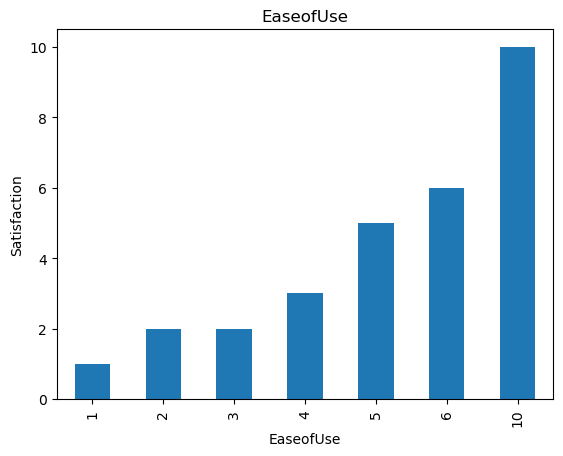

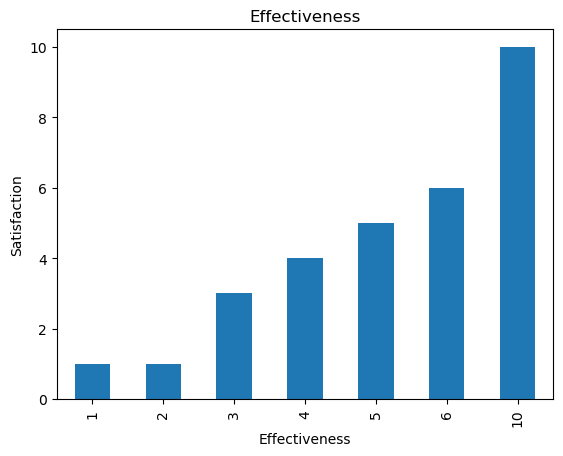

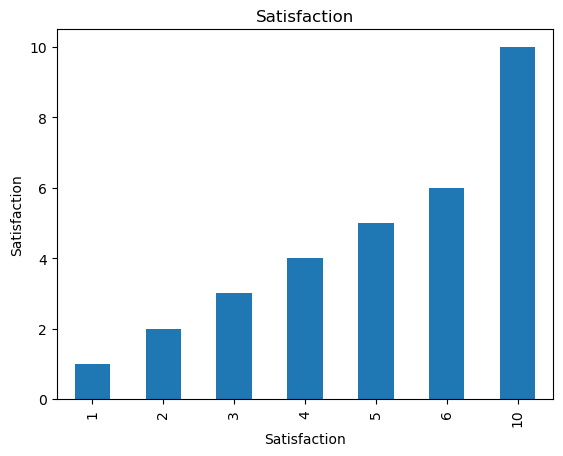

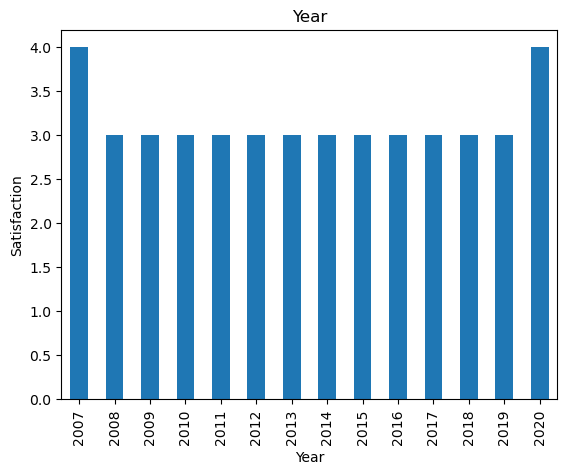

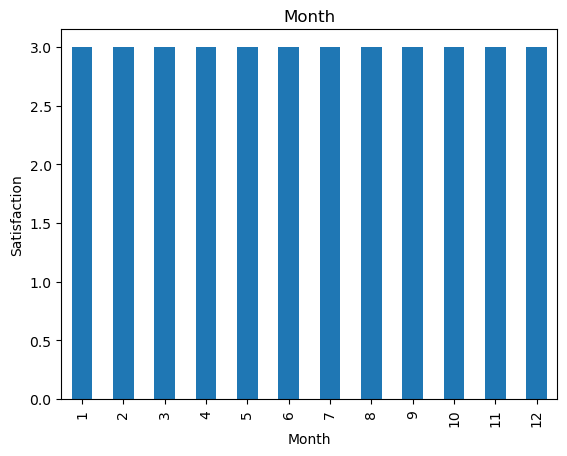

In [26]:
#Finding Relationship with Discrete features and Satisfaction

for feature in discrete_feature:
    df = data1.copy()
    df.groupby(feature)['Satisfaction'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Satisfaction')
    plt.title(feature)
    plt.show()

From the graph it is evident that as the Ease of use and Effectiveness increased the satisfaction levels also increased.

**UNIVARIATE ANALYSIS**

**Histogram**

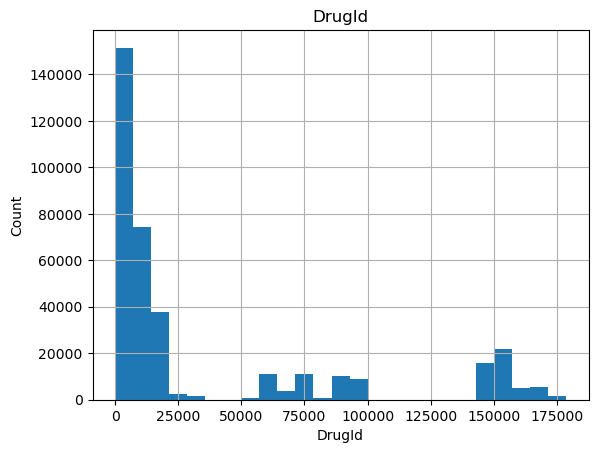

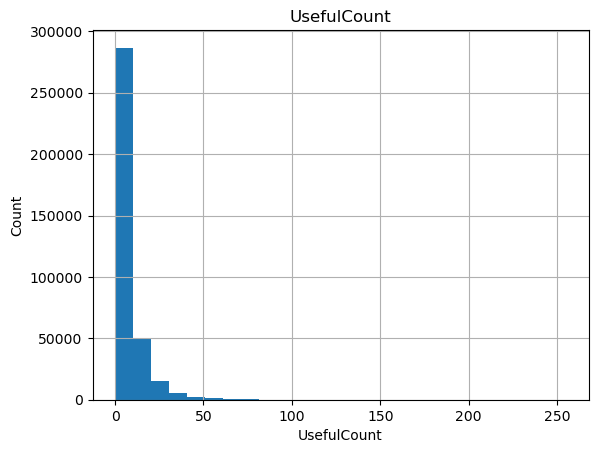

In [27]:
#Analyzing the Distribution of Continuous variables

for feature in continuous_feature:
    df = data1.copy()
    df[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

The histogram shows that the data distribution is skewed.

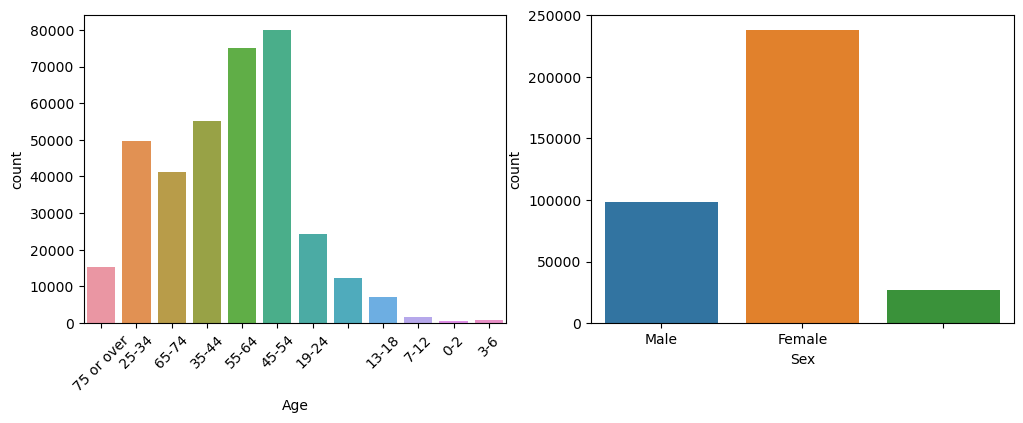

In [28]:
# Bar Charts of some categorical columns

plt.figure(figsize=(12, 4))
plt.subplot(121)
sns.countplot(data=data1, x='Age')
plt.xticks(rotation=45)
plt.subplot(122)
sns.countplot(data=data1, x='Sex')
plt.show()

From the graph it is evident that females users are more than male users. And the age age group of 45-54 are predominant users than other age group.

# Top 20 Drugs based on No. of Users

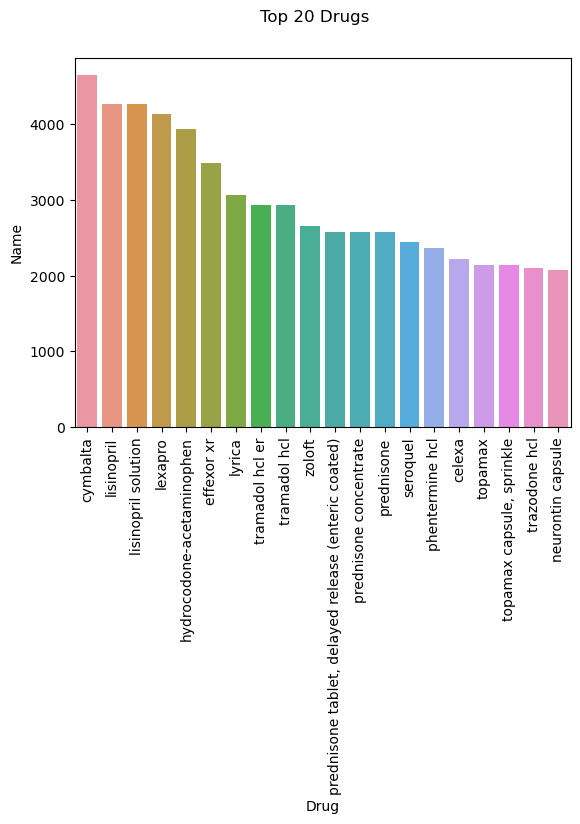

In [29]:
data_= data1['Drug'].value_counts().head(20).reset_index()
data_.columns = ['Drug', 'Name']
sns.barplot(data=data_, x = 'Drug', y = 'Name')
plt.suptitle("Top 20 Drugs")
plt.xticks(rotation=90,fontsize=10)
plt.show()

So the most commmonly used drug is cymbalta followed by lisinopril. All these 20 druge were used by more than 2000 people.

# Top 15 Conditions

Text(0, 0.5, 'Users')

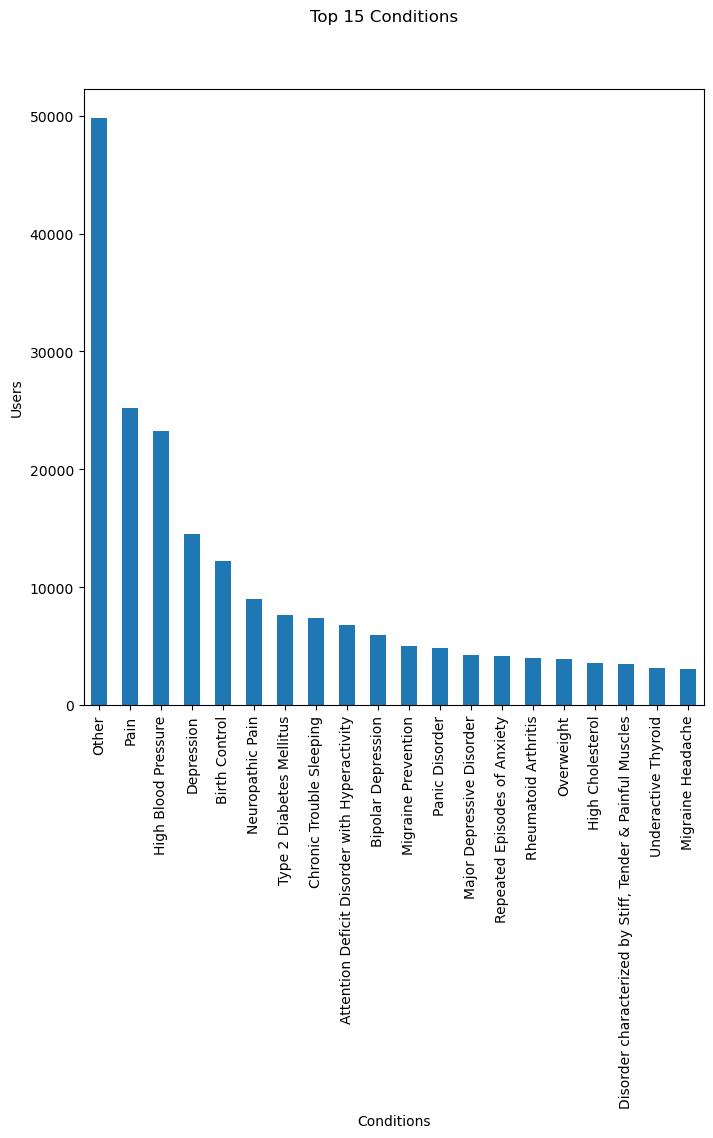

In [30]:
data['Condition'].value_counts().nlargest(20).plot(kind='bar',figsize=(8,8))
plt.suptitle("Top 15 Conditions")
plt.xlabel('Conditions')
plt.ylabel('Users')

#### As much as 50,000 users have reported other conditions followed by Pain topped the list with more than 25000 people reporting it.

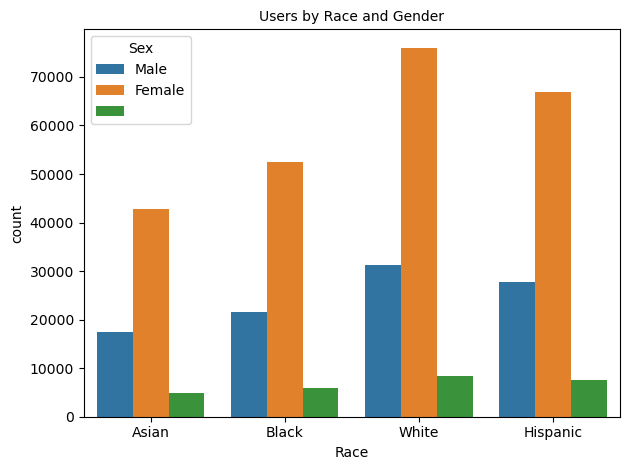

In [31]:
sns.countplot(x='Race',hue='Sex',data=data1)
plt.title("Users by Race and Gender", fontsize = 10)
plt.tight_layout()
plt.show()

In all the races females are using drugs more than males and others.

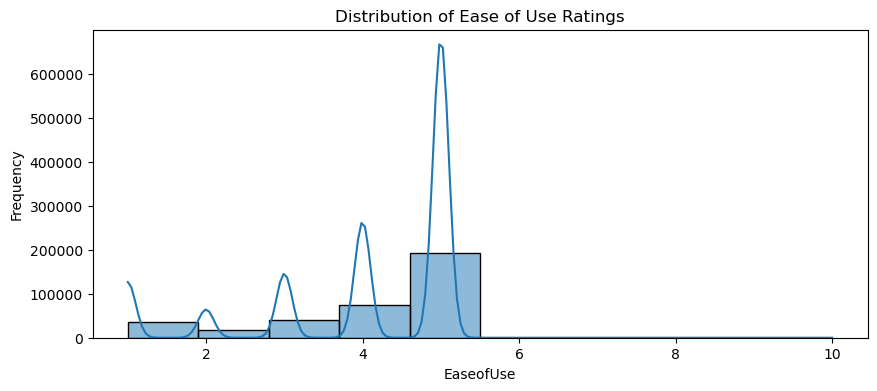

Mean EaseofUse: 4.02
Median EaseofUse: 5.00
Standard Deviation EaseofUse: 1.32


In [32]:
plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='EaseofUse', bins=10, kde=True)
plt.title('Distribution of Ease of Use Ratings')
plt.xlabel('EaseofUse')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
easeofuse_mean = data['EaseofUse'].mean()
easeofuse_median = data['EaseofUse'].median()
easeofuse_std = data['EaseofUse'].std()
print(f"Mean EaseofUse: {easeofuse_mean:.2f}")
print(f"Median EaseofUse: {easeofuse_median:.2f}")
print(f"Standard Deviation EaseofUse: {easeofuse_std:.2f}")

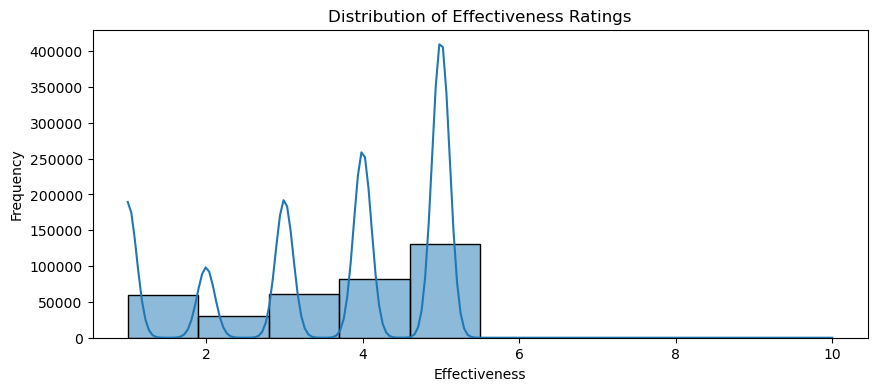

Mean Effectiveness: 3.53
Median Effectiveness: 4.00
Standard Deviation Effectiveness: 1.46


In [33]:
plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='Effectiveness', bins=10, kde=True)
plt.title('Distribution of Effectiveness Ratings')
plt.xlabel('Effectiveness')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
effectiveness_mean = data['Effectiveness'].mean()
effectiveness_median = data['Effectiveness'].median()
effectiveness_std = data['Effectiveness'].std()
print(f"Mean Effectiveness: {effectiveness_mean:.2f}")
print(f"Median Effectiveness: {effectiveness_median:.2f}")
print(f"Standard Deviation Effectiveness: {effectiveness_std:.2f}")

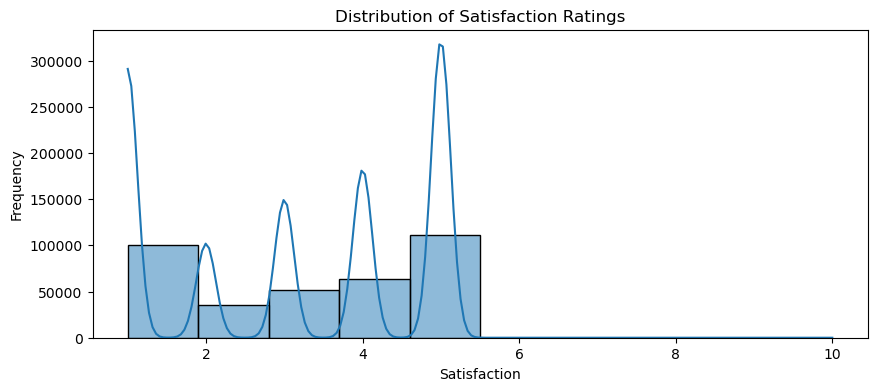

Mean Satisfaction: 3.14
Median Satisfaction: 3.00
Standard Deviation Satisfaction: 1.61


In [34]:
plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='Satisfaction', bins=10, kde=True)
plt.title('Distribution of Satisfaction Ratings')
plt.xlabel('Satisfaction')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
satisfaction_mean = data['Satisfaction'].mean()
satisfaction_median = data['Satisfaction'].median()
satisfaction_std = data['Satisfaction'].std()
print(f"Mean Satisfaction: {satisfaction_mean:.2f}")
print(f"Median Satisfaction: {satisfaction_median:.2f}")
print(f"Standard Deviation Satisfaction: {satisfaction_std:.2f}")

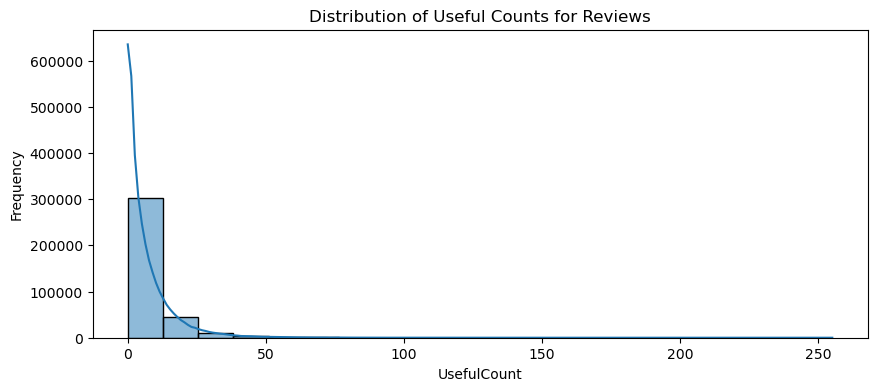

Mean UsefulCount: 6.74
Median UsefulCount: 4.00
Standard Deviation UsefulCount: 9.32


In [35]:
plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='UsefulCount', bins=20, kde=True)
plt.title('Distribution of Useful Counts for Reviews')
plt.xlabel('UsefulCount')
plt.ylabel('Frequency')
plt.show()

# Summary statistics
usefulcount_mean = data['UsefulCount'].mean()
usefulcount_median = data['UsefulCount'].median()
usefulcount_std = data['UsefulCount'].std()
print(f"Mean UsefulCount: {usefulcount_mean:.2f}")
print(f"Median UsefulCount: {usefulcount_median:.2f}")
print(f"Standard Deviation UsefulCount: {usefulcount_std:.2f}")

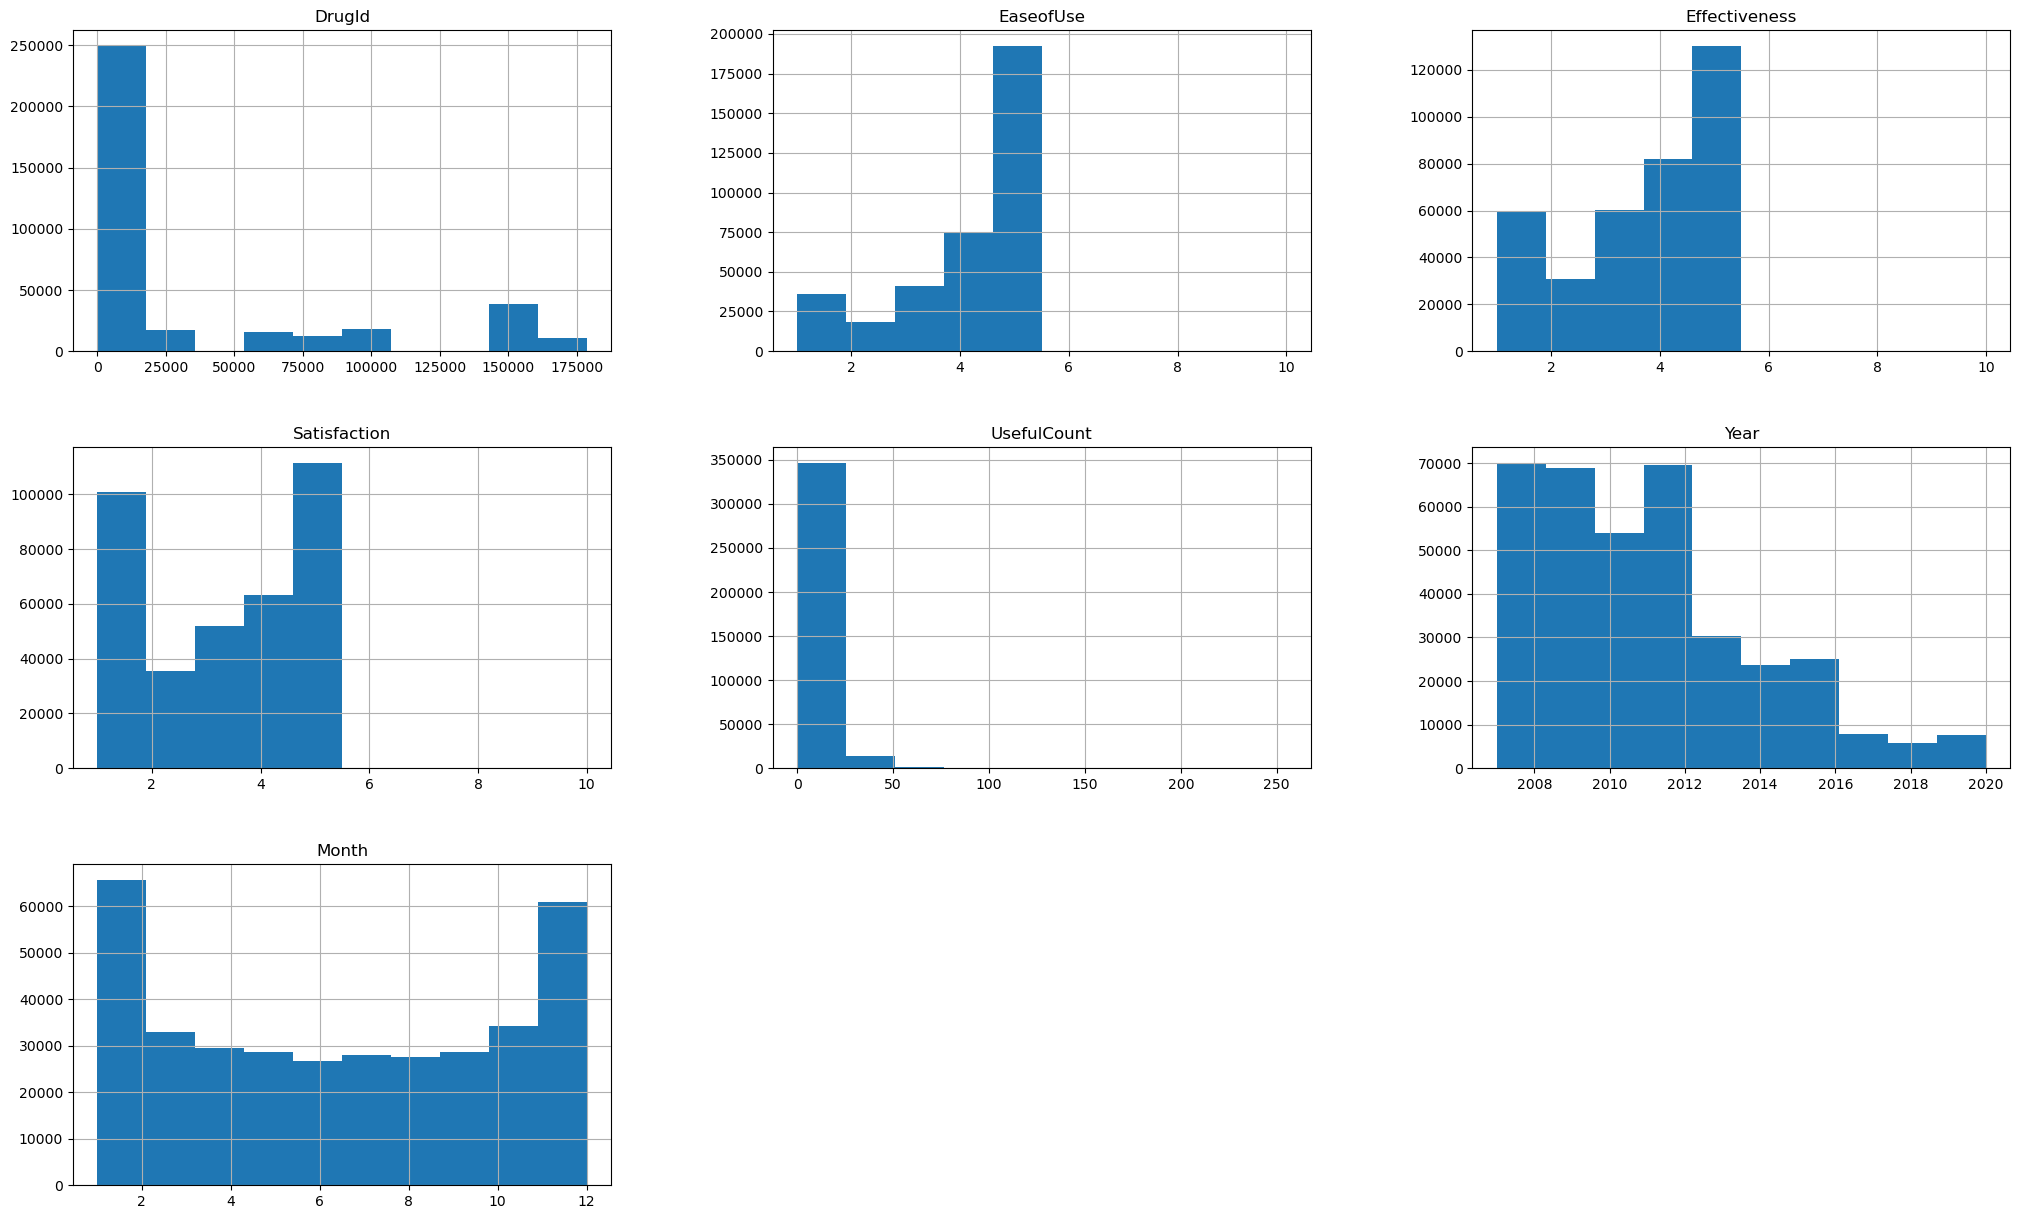

In [36]:
#plot graphs for float and int data types
freqgraph = data1.select_dtypes(include=['int'])
freqgraph.hist(figsize=(25,15))
plt.show()

<Figure size 1000x800 with 0 Axes>

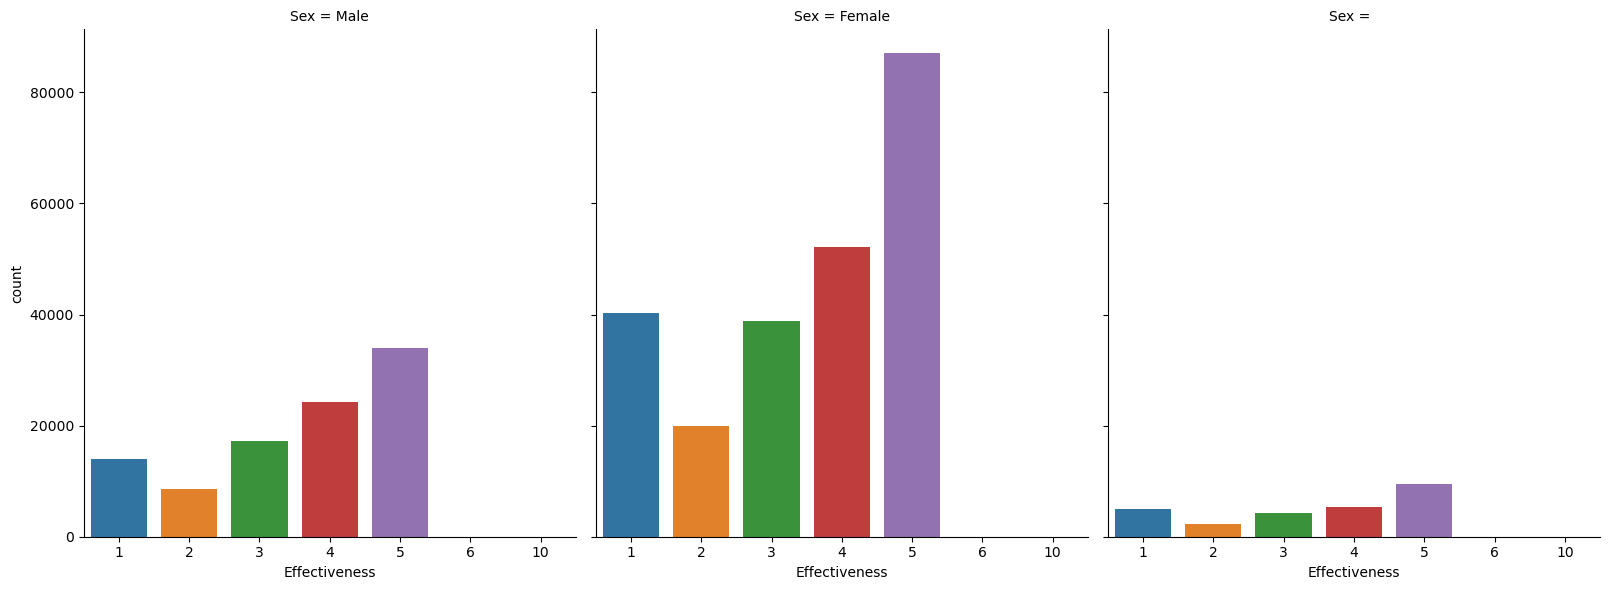

In [37]:
plt.figure(figsize=(10,8))
g = sns.catplot(x="Effectiveness",col="Sex",
                data=data1, kind="count",
                height=6,aspect =.9);

In females efffectiveness of 5 was observed for more than 60000 users.

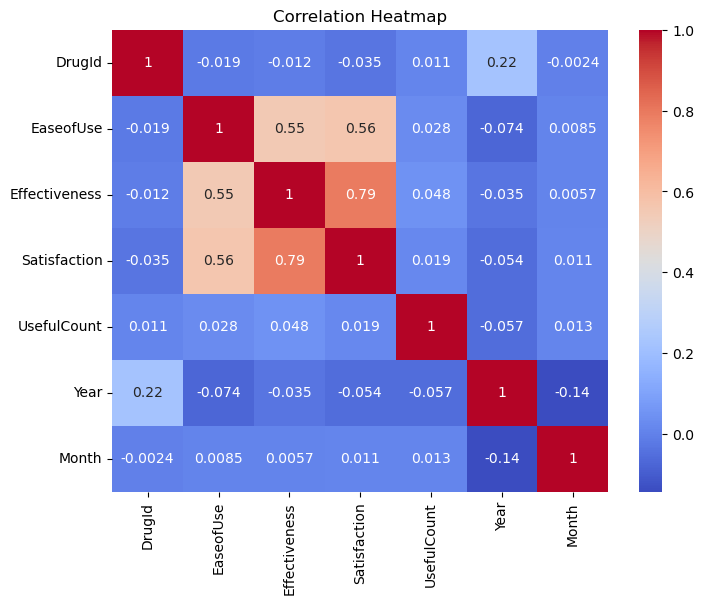

In [38]:
# Correlation heatmap
corr_matrix = data1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

From the heatmap a positive correlation is found between EaseofUse and effectiveness, Effectiveness and satisfaction and ease of use and satisfaction

# Preprocessing

In [39]:
# Check for missing values:

data1.isna().sum()

Name              0
Race              0
Age               0
Condition         0
Date              0
Drug              0
DrugId            0
EaseofUse         0
Effectiveness     0
Reviews          37
Satisfaction      0
Sex               0
SideEffects       0
UsefulCount       0
Year              0
Month             0
day_of_week       0
dtype: int64

In [40]:
# Nan rows were dropped
data1.dropna(axis = 0, inplace = True)
data1.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
SideEffects      0
UsefulCount      0
Year             0
Month            0
day_of_week      0
dtype: int64

In [41]:
# Handling instances with whitespaces
for i in data1:
    data1[i]=np.where(data1[i]==" ",np.NAN,data1[i])
    
data1.isna().sum()

Name                 0
Race                 0
Age              12199
Condition           43
Date                 0
Drug                 0
DrugId               0
EaseofUse            0
Effectiveness        0
Reviews          41824
Satisfaction         0
Sex              26533
SideEffects      17454
UsefulCount          0
Year                 0
Month                0
day_of_week          0
dtype: int64

In [42]:
data1.dropna(axis=0, inplace = True)
data1.isna().sum()

Name             0
Race             0
Age              0
Condition        0
Date             0
Drug             0
DrugId           0
EaseofUse        0
Effectiveness    0
Reviews          0
Satisfaction     0
Sex              0
SideEffects      0
UsefulCount      0
Year             0
Month            0
day_of_week      0
dtype: int64

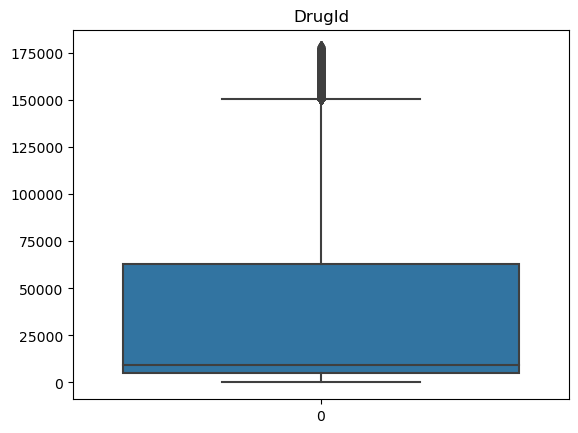

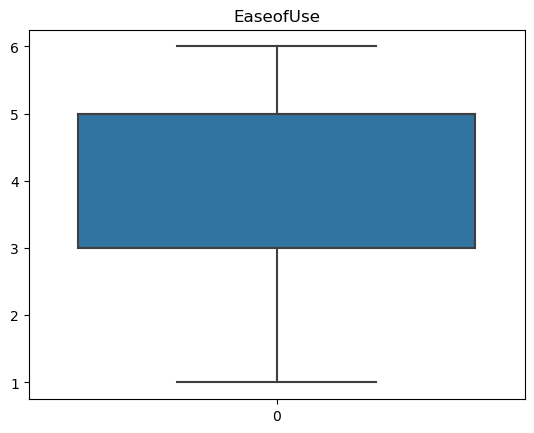

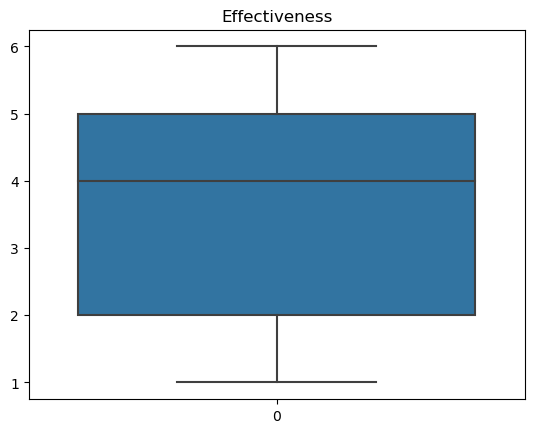

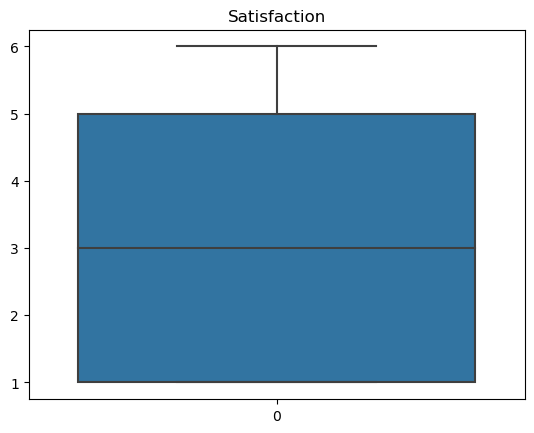

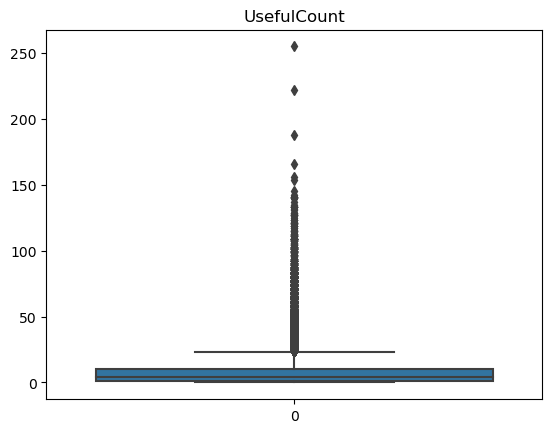

In [43]:
#create a boxplot to display outlier


num_cols = ['DrugId', 'EaseofUse',
       'Effectiveness','Satisfaction','UsefulCount']
for i in num_cols:
    plt.figure()
    sns.boxplot(data1[i])
    plt.title(i)

Drug Id and Useful count column have outliers

In [44]:
# Calculate the quartiles Q1, Q2 (median), and Q3 of the 'DrugId' column :

Q1 = np.percentile(data1['DrugId'],25,interpolation='midpoint')
Q2 = np.percentile(data1['DrugId'],50,interpolation='midpoint')
Q3 = np.percentile(data1['DrugId'],75,interpolation='midpoint')


#print the quartiles

print('Q1 =', Q1)
print('Q2 =', Q2)
print('Q3 =', Q3)

# Calculate the interquartile range (IQR):

IQR = Q3 - Q1

#print iqr

print('IQR =',IQR)

# Define the upper and lower limits for outliers:

up_lim = Q3 + 1.5*IQR
low_lim = Q1 - 1.5*IQR

print ('up_lim = ', up_lim)
print ('low_lim = ', low_lim)


Q1 = 4896.0
Q2 = 9548.0
Q3 = 63163.0
IQR = 58267.0
up_lim =  150563.5
low_lim =  -82504.5


In [45]:
outliers = []

for x in data1 ['DrugId'] :
    if (x>up_lim) or (x<low_lim) :
        outliers.append(x)
print(outliers)

[163180.0, 163180.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 164750.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 167493.0, 167493.0, 167493.0, 167493.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0, 154120.0,

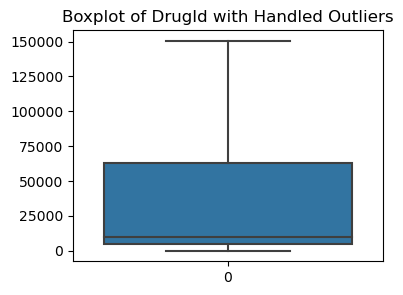

In [46]:
# Handle the outliers in the 'DrugId' column of the dataset by using flooring and capping:

data1['DrugId'] = np.where(data1['DrugId'] > up_lim, up_lim, np.where(data1['DrugId']<low_lim,low_lim,data1['DrugId']))
                                                                                                             
                                                                                                             
 # Again check for outliers after filling:

plt.figure(figsize=(4, 3))
sns.boxplot(data1['DrugId'])
plt.title('Boxplot of DrugId with Handled Outliers')
plt.show()

In [47]:
# Calculate the quartiles Q1, Q2 (median), and Q3 of the 'EaseofUse' column :

Q1 = np.percentile(data1['UsefulCount'],25,interpolation='midpoint')
Q2 = np.percentile(data1['UsefulCount'],50,interpolation='midpoint')
Q3 = np.percentile(data1['UsefulCount'],75,interpolation='midpoint')


#print the quartiles

print('Q1 =', Q1)
print('Q2 =', Q2)
print('Q3 =', Q3)

# Calculate the interquartile range (IQR):

IQR = Q3 - Q1



#print iqr

print('IQR =',IQR)

# Define the upper and lower limits for outliers:

up_lim = Q3 + 1.5*IQR
low_lim = Q1 - 1.5*IQR

print ('up_lim = ', up_lim)
print ('low_lim = ', low_lim)





Q1 = 1.0
Q2 = 4.0
Q3 = 10.0
IQR = 9.0
up_lim =  23.5
low_lim =  -12.5


In [48]:
outliers = []

for x in data1['UsefulCount'] :
    if (x>up_lim) or (x<low_lim) :
        outliers.append(x)
print(outliers)

[29.0, 30.0, 25.0, 25.0, 29.0, 34.0, 35.0, 38.0, 28.0, 36.0, 40.0, 30.0, 48.0, 50.0, 26.0, 60.0, 41.0, 48.0, 54.0, 24.0, 25.0, 33.0, 27.0, 24.0, 24.0, 25.0, 27.0, 45.0, 45.0, 24.0, 59.0, 36.0, 27.0, 24.0, 75.0, 77.0, 66.0, 31.0, 47.0, 25.0, 27.0, 48.0, 32.0, 29.0, 90.0, 25.0, 45.0, 43.0, 38.0, 40.0, 41.0, 24.0, 31.0, 44.0, 35.0, 29.0, 84.0, 38.0, 33.0, 36.0, 32.0, 28.0, 50.0, 25.0, 44.0, 27.0, 43.0, 27.0, 30.0, 29.0, 28.0, 31.0, 55.0, 27.0, 36.0, 33.0, 39.0, 30.0, 33.0, 25.0, 54.0, 24.0, 25.0, 26.0, 42.0, 30.0, 30.0, 27.0, 24.0, 26.0, 45.0, 29.0, 31.0, 25.0, 26.0, 38.0, 35.0, 43.0, 50.0, 33.0, 33.0, 24.0, 24.0, 28.0, 26.0, 26.0, 28.0, 43.0, 24.0, 27.0, 25.0, 42.0, 30.0, 137.0, 28.0, 53.0, 30.0, 30.0, 26.0, 56.0, 38.0, 43.0, 25.0, 27.0, 28.0, 24.0, 35.0, 27.0, 30.0, 38.0, 35.0, 29.0, 27.0, 38.0, 26.0, 31.0, 26.0, 31.0, 29.0, 30.0, 25.0, 29.0, 24.0, 30.0, 26.0, 30.0, 34.0, 26.0, 34.0, 35.0, 66.0, 30.0, 45.0, 32.0, 77.0, 34.0, 25.0, 29.0, 34.0, 24.0, 40.0, 29.0, 28.0, 24.0, 26.0, 48.0, 24

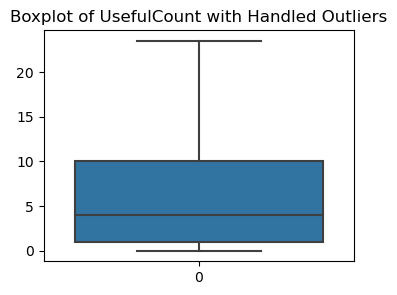

In [49]:
# Handle the outliers in the 'EaseofUse' column of the dataset by using flooring and capping:

data1['UsefulCount'] = np.where(data1['UsefulCount'] > up_lim, up_lim, np.where(data1['UsefulCount']<low_lim,low_lim,data1['UsefulCount']))
                                                                                                          
                                                                                                             
 # Again check for outliers after filling:

plt.figure(figsize=(4, 3))
sns.boxplot(data1['UsefulCount'])
plt.title('Boxplot of UsefulCount with Handled Outliers')
plt.show()

# Standard scaling

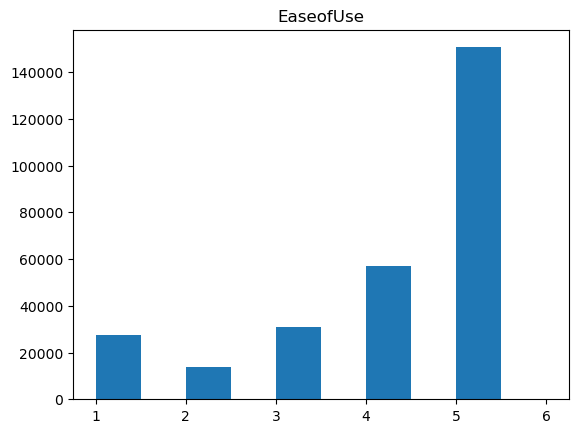

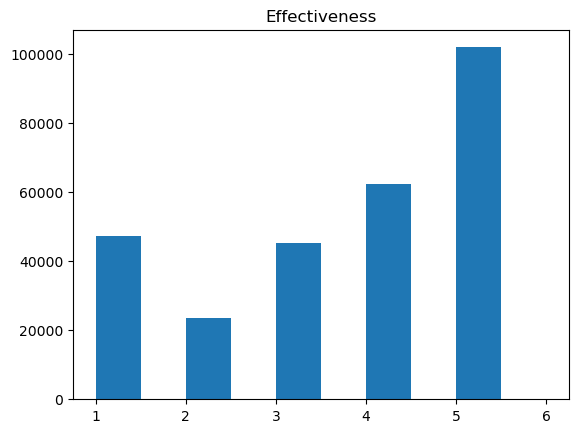

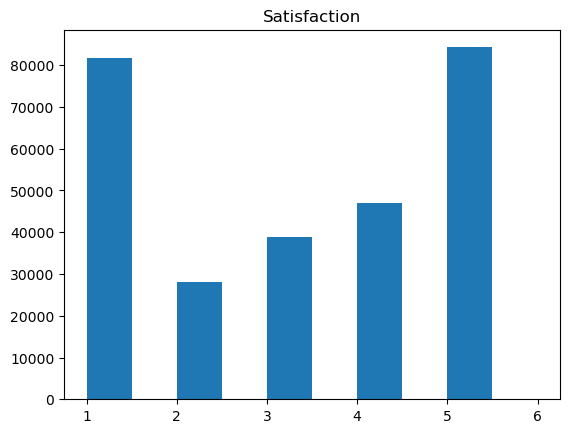

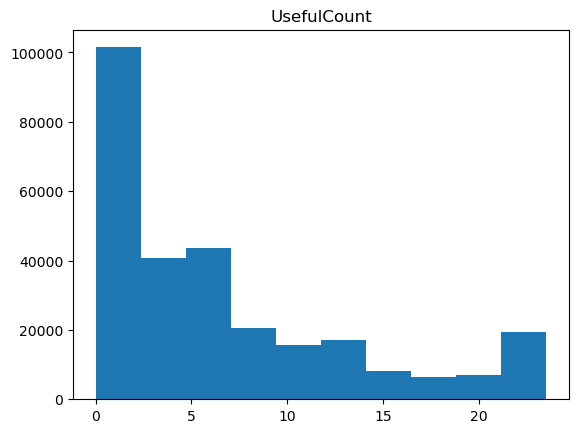

In [50]:
scaler = ['EaseofUse', 'Effectiveness',  'Satisfaction', 'UsefulCount']
for i in scaler:
    plt.figure()
    plt.hist(data1[i])
    plt.title(i)

In [51]:
data1.EaseofUse.skew()

-1.2258195650039612

In [52]:
data1.Effectiveness.skew()

-0.5892773942212327

In [53]:
data1.Satisfaction.skew()

-0.1259113566827465

In [54]:
data1.UsefulCount.skew()

1.1561710842022745

Inorder to remove the skewness in data standard scaling is performed in the UsefulCount and Ease of use  columns

-0.5680717873995585

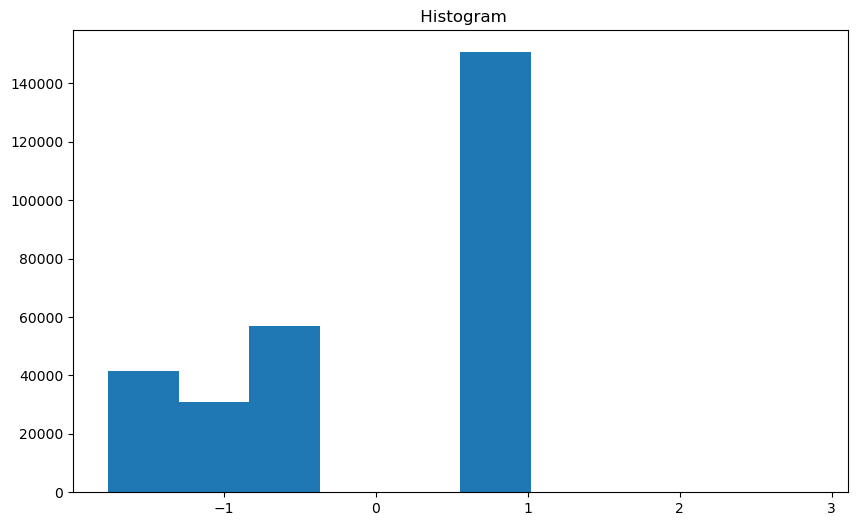

In [55]:
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

data_EaseofUse = pd.DataFrame(data1['EaseofUse'])
data_EaseofUse1 = pipeline.fit_transform(data_EaseofUse)

plt.figure(figsize=(10,6))
plt.hist(data_EaseofUse1)
plt.title(" Histogram")

data1['EaseofUse_boxcox'] = data_EaseofUse1
data1.EaseofUse_boxcox.skew()

0.21239077510398616

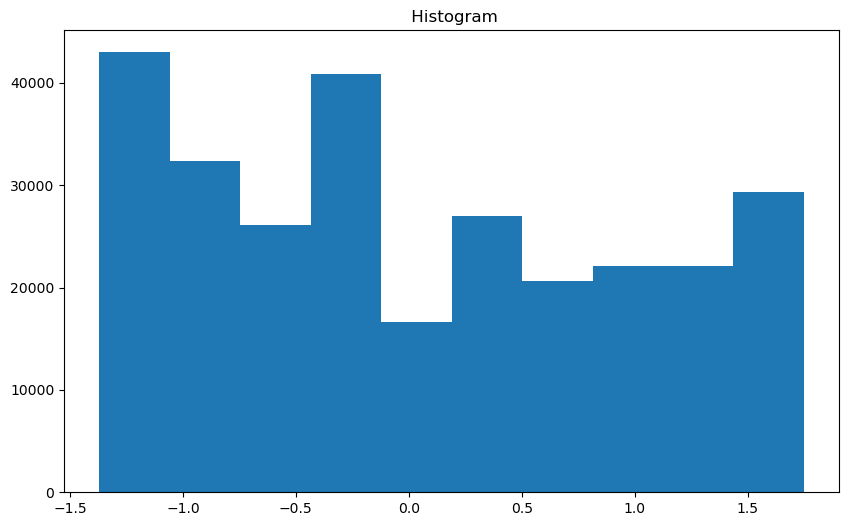

In [56]:
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])

data_UsefulCount = pd.DataFrame(data1['UsefulCount'])
data_UsefulCount1 = pipeline.fit_transform(data_UsefulCount)

plt.figure(figsize=(10,6))
plt.hist(data_UsefulCount1)
plt.title(" Histogram")

data1['UsefulCount_boxcox'] = data_UsefulCount1
data1.UsefulCount_boxcox.skew()